In [ ]:
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mkdir test_data
#test data 폴더 생성

In [ ]:
import os

In [ ]:
one_path = '/content/drive/MyDrive/폭력 이미지 소스/폭력'
two_path = '/content/drive/MyDrive/폭력 이미지 소스/비폭력'

print(len(os.listdir(one_path)))
print(len(os.listdir(two_path)))

500
500


In [ ]:
#for file_path in os.listdir(two_path)[:11]: #비폭력 11개 제거
 # os.remove(os.path.join(two_path, file_path)) #500개 맞추기 위해서 비폭력 데이터 일부 제거


In [ ]:
#print(len(os.listdir(two_path)))

500


In [ ]:
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import splitfolders

splitfolders.ratio('/content/drive/MyDrive/폭력 이미지 소스', output='test_data', seed=43, ratio=(.7, .3)) #7:3비율로 train 데이터와 test 데이터로 분리

Copying files: 1000 files [00:18, 53.84 files/s]


In [ ]:
print(len(os.listdir('/content/test_data/train/비폭력')))
print(len(os.listdir('/content/test_data/train/폭력')))

print(len(os.listdir('/content/test_data/val/비폭력')))
print(len(os.listdir('/content/test_data/val/폭력')))

350
350
150
150


In [ ]:
import pandas as pd 
import numpy as np
import tensorflow as tf
from keras.preprocessing.image import * 
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os 

In [ ]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from keras.models import Model
from tensorflow.keras import optimizers, regularizers, callbacks

In [ ]:
input_tensor = Input(shape=(180,180,3)) #58 나온 원래 코드 150, 150, 3 #224가 디폴트값임.
model = VGG16(weights='imagenet', include_top=False, input_tensor = input_tensor)

58889256/58889256 [==============================] - 2s 0us/step


In [ ]:
# 모델 Layer 데이터화
layer_dict = dict([(layer.name, layer) for layer in model.layers])

# Layer 추가
x = layer_dict['block5_pool'].output
# Cov2D Layer +
x = Conv2D(filters = 64, kernel_size=(3, 3), activation='relu', padding='SAME')(x)
# MaxPooling2D Layer +
x = MaxPooling2D(pool_size=(2, 2), padding='SAME')(x)
# Flatten Layer +
x = Flatten()(x)
# FC Layer +
x = Dense(2048, activation='relu')(x)
x = Dropout(0.4)(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.4)(x)
x = Dense(2, activation='sigmoid')(x)

# new model 정의
new_model = Model(inputs = model.input, outputs = x)

In [ ]:
# CNN Pre-trained 가중치를 그대로 사용할때
for layer in new_model.layers[:19] :
    layer.trainable = False

new_model.summary()

# 컴파일 옵션
new_model.compile(loss='sparse_categorical_crossentropy',
                     optimizer= tf.keras.optimizers.Adam(learning_rate=0.001),
                     metrics=['accuracy'])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

In [ ]:
# 테스트 데이터 (폭력/비폭력)
train_dir ='/content/test_data/train'
test_dir = '/content/test_data/val'

# 폴더에 따라 자동 분류
train_image_generator = ImageDataGenerator(rescale=1./255,
                                           rotation_range=15,
                                           zoom_range=0.2,
                                           horizontal_flip=True,
                                           )
#데이터 증강,변형
test_image_generator = ImageDataGenerator(rescale=1./255)

# 데이터 구조 생성
train_data_gen = train_image_generator.flow_from_directory(batch_size=100,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(180, 180),
                                                           class_mode='binary')

test_data_gen = test_image_generator.flow_from_directory(batch_size=100,
                                                         directory=test_dir,
                                                         target_size=(180, 180),
                                                         class_mode='binary')

Found 700 images belonging to 2 classes.
Found 300 images belonging to 2 classes.


In [ ]:
history = new_model.fit(train_data_gen, epochs=50,
                        validation_data=test_data_gen)

Epoch 1/50
7/7 [==============================] - 48s 4s/step - loss: 1.1420 - accuracy: 0.5300 - val_loss: 0.6976 - val_accuracy: 0.5000
Epoch 2/50
7/7 [==============================] - 30s 4s/step - loss: 0.6929 - accuracy: 0.4971 - val_loss: 0.6883 - val_accuracy: 0.5000
Epoch 3/50
7/7 [==============================] - 29s 4s/step - loss: 0.6789 - accuracy: 0.5000 - val_loss: 0.6589 - val_accuracy: 0.5767
Epoch 4/50
7/7 [==============================] - 30s 5s/step - loss: 0.6438 - accuracy: 0.6114 - val_loss: 0.6116 - val_accuracy: 0.6900
Epoch 5/50
7/7 [==============================] - 29s 5s/step - loss: 0.5948 - accuracy: 0.6943 - val_loss: 0.5944 - val_accuracy: 0.7467
Epoch 6/50
7/7 [==============================] - 33s 5s/step - loss: 0.5627 - accuracy: 0.7657 - val_loss: 0.5814 - val_accuracy: 0.7267
Epoch 7/50
7/7 [==============================] - 33s 5s/step - loss: 0.4916 - accuracy: 0.7857 - val_loss: 0.5046 - val_accuracy: 0.7933
Epoch 8/50
7/7 [==================

In [ ]:
new_model.save("newVGG16(폭력비폭력).h5")

In [ ]:
# 최종 결과 리포트
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

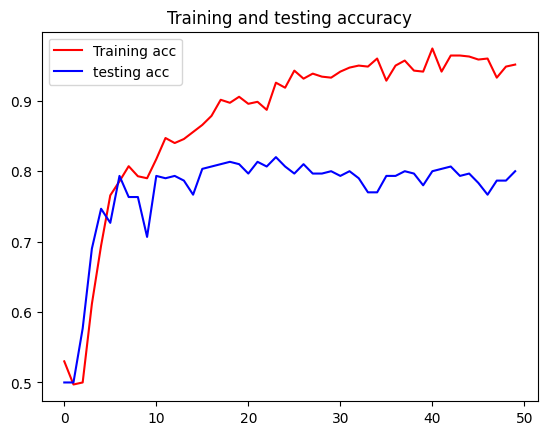

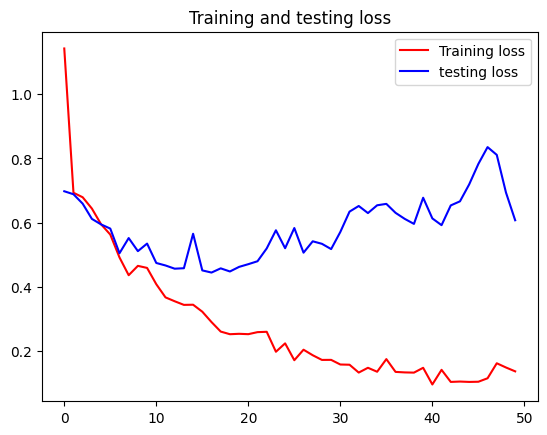

In [ ]:
from matplotlib import pyplot as plt

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='testing acc')
plt.title('Training and testing accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='testing loss')
plt.title('Training and testing loss')
plt.legend()

plt.show()